# Проект  #

## По методам оптимизации ##

## Егор Емелина 778 ##

Логистическая регрессия — один из видов линейных классификаторов. Одной из ее особенностей является возможность оценивания вероятностей классов, тогда как большинство линейных классификаторов могут выдавать только номера классов. Логистическая регрессия использует достаточно сложный функционал качества, который не допускает записи решения в явном виде (в отличие от, например, линейной регрессии). Тем не менее, логистическую регрессию можно настраивать с помощью градиентного спуска. Мы будем работать с выборкой, содержащей два признака. Будем считать, что ответы лежат в множестве {-1, 1}. Для настройки логистической регрессии будем решать следующую задачу:

$\frac{1}{l}\sum_{i=1}^l log(1+exp(-y_i(< w,x_i>)) + \frac{1}{2}\mu||w||_2^2 \rightarrow {\underset{w}{min}}$,

где $y_i$ - $i$-ый ответ, $x_i$ - $i$-ая строка признаков(признаки i-го объекта),$w$ - вектор весов, который и нужно найти.

Градиентный шаг для весов будет заключаться в одновременном обновлении весов $w_i$ по следующим формулам:

$w_i = w_i + k \frac{1}{l}\sum_{i=1}^l y_ix_i(1 - \frac{1}{1+exp(-y_i<w,x_i>)}) - k\mu w_i$,

где $k$ - размер шага.

Линейные методы могут переобучаться и давать плохое качество из-за различных проблем в данных: мультиколлинеарности, зашумленности и т.д. Чтобы избежать этого, следует использовать регуляризацию — она позволяет понизить сложность модели и не допустить переобучения. Сила регуляризации определяется коэффициентом $\mu$ в формулах, указанных выше. Вторая норма в регуляризации сокращает веса признаков и тем самым борется с мультиколлинеарностью.

Загрузим данные из файла "mushrooms.txt". Это двумерная выборка, целевая переменная на которой принимает значения 1 или 2. Так как вектор ответов $y$ должен принимать значения из множества{-1,1}, то преобразуем его к нужному виду.

In [4]:
from joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from scipy.sparse import csr_matrix
import numpy.linalg as ln
import math
import random
import matplotlib.pyplot as plt

In [5]:
mem = Memory("./mycache")

@mem.cache
def get_data():
    data = load_svmlight_file("mushrooms.txt")
    return data[0], data[1]

X, y = get_data()

In [6]:
X = csr_matrix(X)

In [7]:
for i in range(len(y)):
        if (y[i] == 2):
            y[i] = 1
        else:
            y[i] = -1

Дважды непрерывно дифференцируемая функция
 $f(x)$ является $L$-гладкой тогда и только тогда, 
когда $||\nabla^2 f(x) || \leq L$ для всех $x\in R^d$. Найдем отсюда константу $L$ для нашей функции $f(x)$.

$f(x) = \sum_{i}g(y_i<w,x_i>) = \mu\frac{1}{2}||x||_2^2$

$g(z) = log (1+e^{-z})$

$g(z)' = -\frac{1}{1+e^{z}}$

$g(z)'' = \frac{e^z}{(1+e^{z})^2}\in (0,\frac{1}{4}]$

$\nabla f(x) = \sum_{i} y_i x_i g'(y_i<w,x_i>) + \mu w$

$\nabla^2 f(x) = \sum_{i} x_i g''(y_i<w,x_i>)x_i' + \mu I$

Тогда:

$L\geq \mu +\frac{1}{4} {\underset{i}{max}}||x_i||_2^2$, где $x_i$ - $i$-ая строчка матрицы признаков.

Для нашего примера будем брать $L = \mu + 110$.



Найдем константу сильной выпуклости функции $f(x)$. Вспомним, что $f(x)$ - сильно выпукла с константой $\mu >0$, если $\nabla^2 f(x) \succ \mu I$. Но:

$\nabla^2 f(x) = \sum_{i} x_i g''(y_i<w,x_i>)x_i' + \mu I$, а 

$g(z)'' \in (0,\frac{1}{4}]$, тогда константа сильной выпуклости равна $\mu$.

Реализуем градиентный спуск для $L2$-регуляризации (с коэффициентом регуляризации 10) логистической регрессии. Используем длину шага $k=0.1$. В качестве начального приближения будем использовать нулевой вектор.

In [8]:
w = np.zeros(112)

In [9]:
w_prev = np.zeros(112)
x1  = []
y1 = []

In [10]:
def f(X, y, w, k, C):
    l = len(y)
    w1 = 0
    for i in range(l):
        w1 = w1 + (1.0 / l)*math.log((1+math.exp(-y[i]*(X[i].dot(w))))+C/2*ln.norm(w)**2)
    return w1

In [11]:
def df(X, y, w, k, C):
    l = len(y)
    w1 = np.zeros(112)
    for i in range(112):
        w1[i] = 1.0- 1.0 / (1.0 + math.exp(-y[i] * (X[i].dot(w))))
        
    w =  ((1.0 / l))*(X.transpose().dot(y)) * w1 -   C * w
    return w

In [12]:
def calc_w(X, y, w, k, C):
    l = len(y)
    w1 = np.zeros(112)
    for i in range(112):
        w1[i] = 1.0- 1.0 / (1.0 + math.exp(-y[i] * (X[i].dot(w))))
        
    w =  w + (k * (1.0 / l))*(X.transpose().dot(y)) * w1 - k * C * w
    return w

In [13]:
def gradient(X, y, w, k, C):
    precision = 1e-15
    w_prev = w
    w = calc_w(X, y, w, k, C)
    count = 1
    x1.append(count)
    y1.append(abs(f(X, y, w, k, C)))
    y2.append(ln.norm(df(X, y, w, k, C)))
    while ((ln.norm(w - w_prev)) > precision):
        w_prev = w
        w = calc_w(X, y, w, k, C)
        count = count + 1
        x1.append(count)
        y1.append(abs(f(X, y, w, k, C)))
        y2.append(ln.norm(df(X, y, w, k, C)))
        
    return w

In [14]:
k = 0.1
C = 10
w = np.zeros(112)
x1  = []
y1 = []
y2 = []
w_ans = (gradient(X, y, w, k, C))

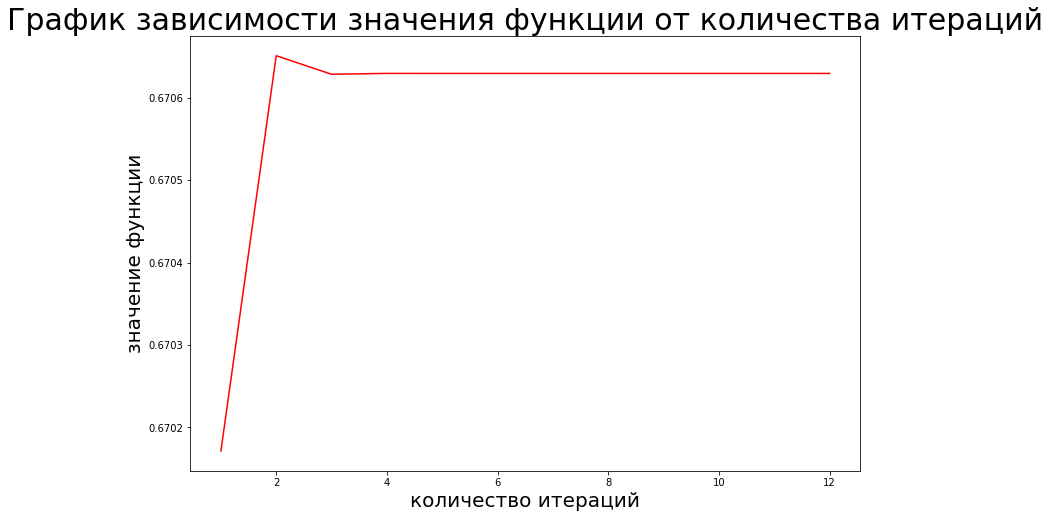

In [384]:
plt.figure(figsize=(12, 8))
plt.plot(x1,y1,color = 'r')
plt.title('График зависимости значения функции от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("значение функции",fontsize=20)
plt.show() 

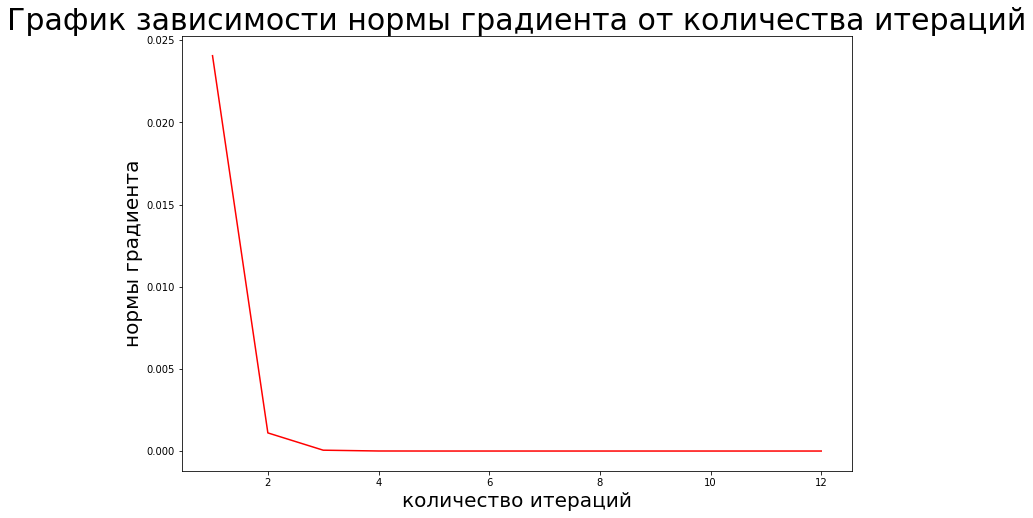

In [385]:
plt.figure(figsize=(12, 8))
plt.plot(x1,y2,color = 'r')
plt.title('График зависимости нормы градиента от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("нормы градиента",fontsize=20)
plt.show()   

Исследуем  ROC - кривую. ROC-кривая — график, позволяющий оценить качество бинарной классификации, отображает соотношение между чувствительностью алгоритма классификации(англ. true positive rate, TPR), и специфичностью алгоритма классификации(англ. false positive rate, FPR). Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию). Чем ближе значение AUC к 1, тем лучше работает классификатор.На вход функции roc_auc_score нужно подавать оценки вероятностей, подсчитанные обученным алгоритмом. Для этого воспользуемся сигмоидной функцией:

$a_i(x) = \frac{1}{1+exp(<w,x_i>)}$

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
def a(X, w):
    ans = np.zeros(len(y))
    for i in range(len(y)):
        ans[i] = ans[i] + X[i].dot(w)
    return ans
    

y_proba = a(X, w_ans)

auc = roc_auc_score(y, y_proba)


In [20]:
auc

0.9764325430038411

# SAG#

 Теперь рассмотрим стохастический градиентный спуск.

In [526]:
w_prev = np.zeros(112)

In [527]:
def calc_w(X, y, w, k, C):
    l = len(y)
    w1 = np.zeros(112)
    j = random.randint(0,112)
    for i in range(112):
        w1[i] = 1.0- 1.0 / (1.0 + math.exp(-y[j] * (X[j].dot(w))))
        
    w =  w + (k * (1.0 / l))*(X.transpose().dot(y)) * w1 - k * C * w
    return w

In [528]:
def gradient(X, y, w, k, C):
    precision = 1e-5
    w_prev = w
    w = calc_w(X, y, w, k, C)
    count = 1
    x1_2.append(count)
    y1_2.append(abs(f(X, y, w, k, C)))
    y2_2.append(ln.norm(df(X, y, w, k, C)))
    while ((ln.norm(w - w_prev)) > precision and count < 20):
        w_prev = w
        w = calc_w(X, y, w, k, C)
        count = count + 1
        x1_2.append(count)
        y1_2.append(abs(f(X, y, w, k, C)))
        y2_2.append(ln.norm(df(X, y, w, k, C)))
        
    return w

In [529]:
k = 0.1
C = 10
w = np.zeros(112)
x1_2  = []
y1_2 = []
y2_2 = []
w_ans = (gradient(X, y, w, k, C))

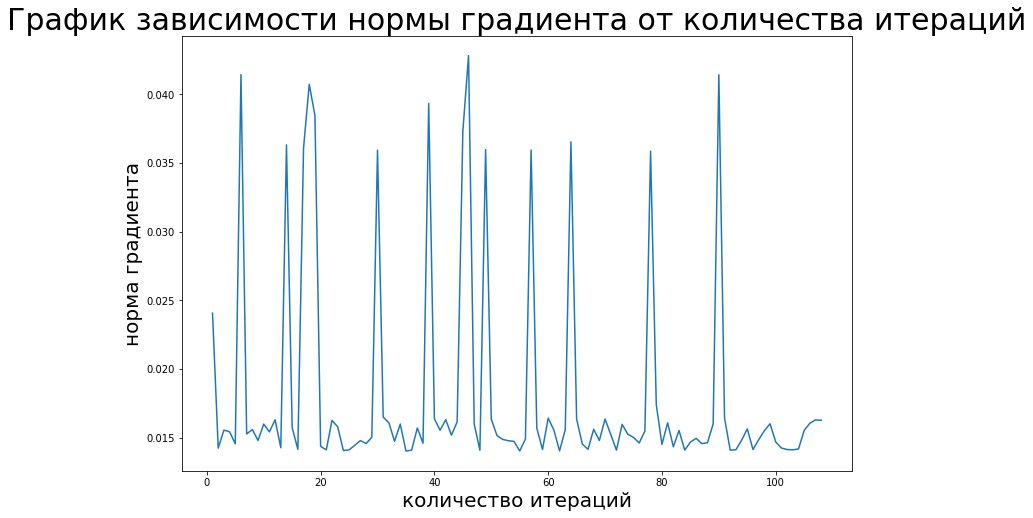

In [224]:
plt.figure(figsize=(12, 8))
plt.plot(x1_2,y2_2)
plt.title('График зависимости нормы градиента от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("норма градиента",fontsize=20)
plt.show() 

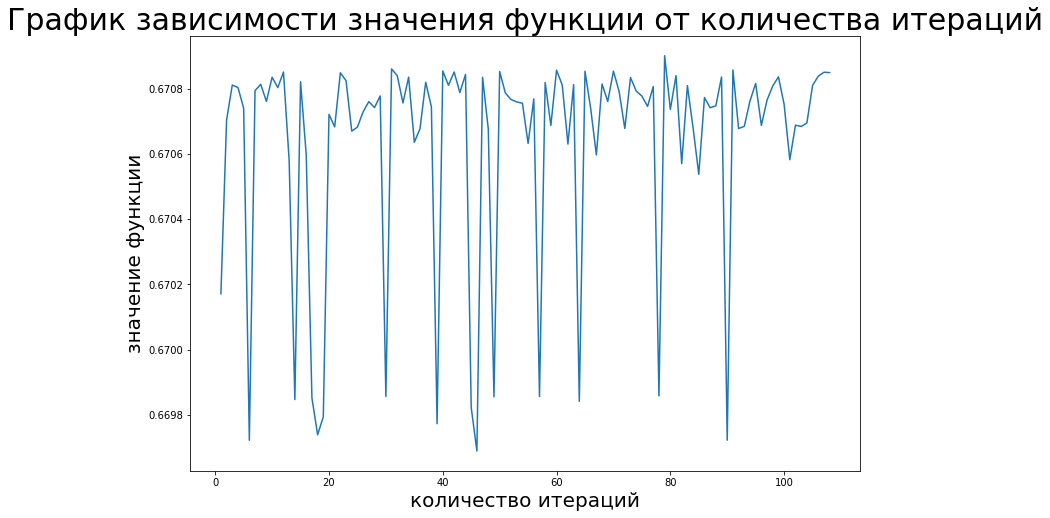

In [225]:
plt.figure(figsize=(12, 8))
plt.plot(x1_2,y1_2)
plt.title('График зависимости значения функции от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("значение функции",fontsize=20)
plt.show() 

# Правило Армихо#

Воспользуемся правилом Армихо для стохастического градиентного спуска. Первоначальный щаг : $k = 0.1$. $\tau=0.5$ - деление шага.

In [492]:
def calc_w_arm(X, y, w, k, C):
    l = len(y)
    w1 = np.zeros(112)
    j = random.randint(0,112)
    for i in range(112):
        w1[i] = 1.0- 1.0 / (1.0 + math.exp(-y[j] * (X[j].dot(w))))
    
        
    w =  w + (k * (1.0 / l))*(X.transpose().dot(y)) * w1 - k * C * w
    return w

In [536]:
def gradient_arm(X, y, w, k, C):
    precision = 1e-5
    tao = 0.5
    w_prev = w
    w = calc_w_arm(X, y, w, k, C)
    count = 1
    x1_arm.append(count)
    y1_arm.append(abs(f(X, y, w, k, C)))
    y2_arm.append(ln.norm(df(X, y, w, k, C)))
    while ((ln.norm(w - w_prev)) > precision and count < 20):
        count = count + 1
        x1_arm.append(count)
        y1_arm.append(abs(f(X, y, w, k, C)))
        y2_arm.append(ln.norm(df(X, y, w, k, C)))
        if (f(X, y, w, k, C) - f(X, y, w_prev, k, C) <= precision*k*(-1)*np.dot(df(X, y, w, k, C),df(X, y, w, k, C))):
            w_prev = w
            w = calc_w_arm(X, y, w, k, C)
        else:
            k = tao * k
        
    return w

In [537]:
w_prev = np.zeros(112)
k = 0.1
C = 10
w = np.zeros(112)
x1_arm  = []
y1_arm = []
y2_arm = []
w_ans = (gradient_arm(X, y, w, k, C))

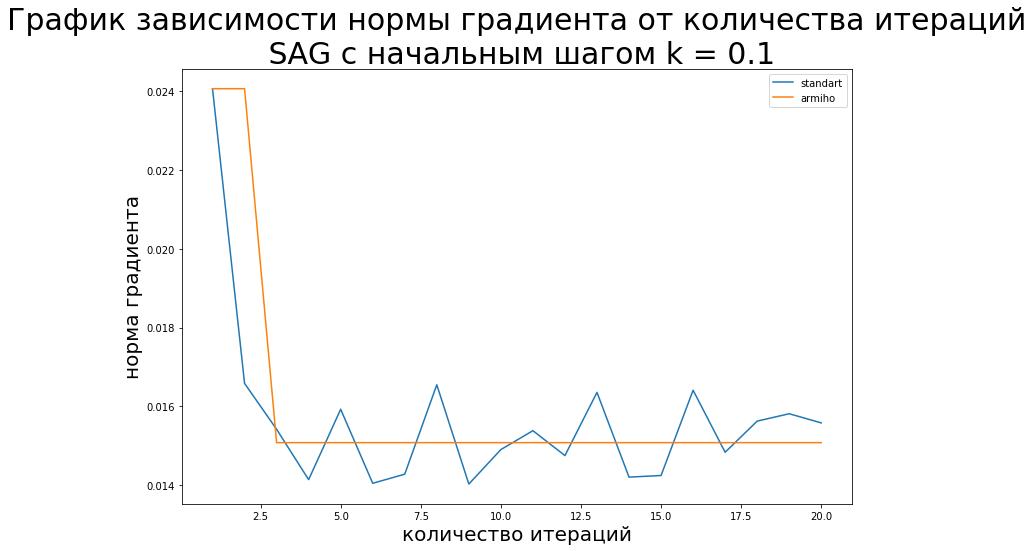

In [542]:
plt.figure(figsize=(12, 8))
plt.plot(x1_2,y2_2,label='standart',markersize = 10)
plt.plot(x1_arm,y2_arm,label='armiho',markersize = 10)
plt.title('График зависимости нормы градиента от количества итераций\n SAG c начальным шагом k = 0.1', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("норма градиента",fontsize=20)
plt.legend()
plt.show() 

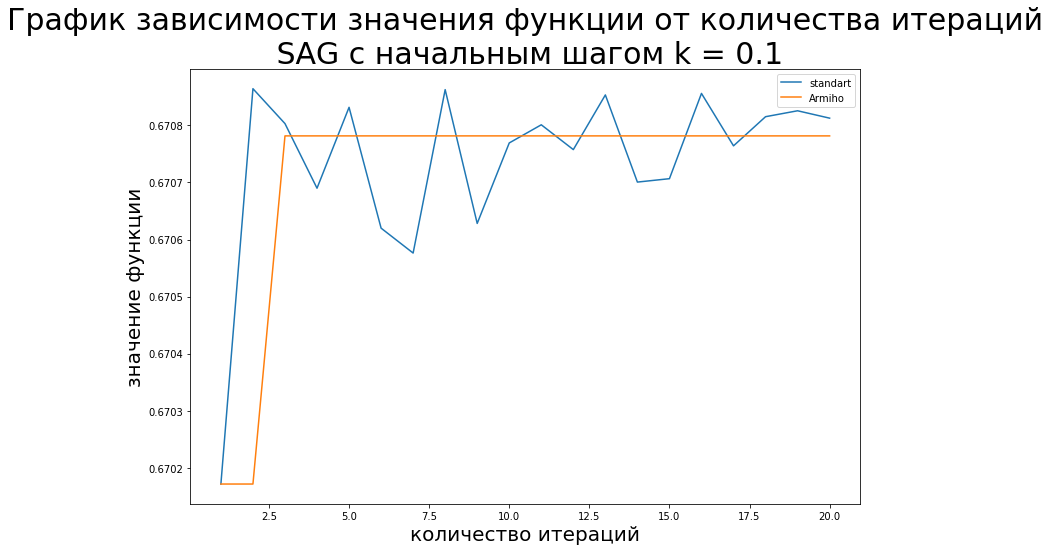

In [543]:
plt.figure(figsize=(12, 8))
plt.plot(x1_2,y1_2,label='standart',markersize = 10)
plt.plot(x1_arm,y1_arm,label='Armiho',markersize = 10)
plt.title('График зависимости значения функции от количества итераций\n SAG c начальным шагом k = 0.1', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("значение функции",fontsize=20)
plt.legend()
plt.show() 

Недостатки стохастическго градиентного спуска:
* возможно застревание в локальном минимуме
* возможна расходимость или медленная сходимость
* возможно переобучение

# Нестрерова #

Теперь рассмотрим метод Нестерова. Для начала вспомним его:

1. Строим две последовательности $\{x_k\},\{y_k\}$.
2. $x_{k+1} = y_k - \frac{1}{L}\nabla f(x_k)$; $y_{k+1} = x_{k+1} + \frac{\sqrt L-\sqrt\mu}{\sqrt L+\sqrt\mu} (x_{k+1}-x_{k})$.

Так же напомним, что берем $L \approx 100 $.

In [21]:
def df2(X, y, w, k, C):
    l = len(y)
    w1 = np.zeros(112)
    for i in range(112):
        w1[i] = 1.0- 1.0 / (1.0 + math.exp(-y[i] * (X[i].dot(w))))
        
    w =  ((1.0 / l))*(X.transpose().dot(y)) * w1 -   C * w
    return w

In [22]:
def Nester(X, y, w, k, C): 
    x_1 = np.zeros(112)
    df_0 = df2(X, y, x_1, k, C)
    L = 110
    x_k = x_1 + k*df_0 + (L**(1/2)-(C)**(1/2))/(L**(1/2)+(C)**(1/2))*(x_1 - w)
    count = 1
    x1_3.append(count)
    y1_3.append(abs(f(X, y, x_k, k, C)))
    y2_3.append(ln.norm(df(X, y, x_k, k, C)))
    eps = 1e-6
    while ((ln.norm(x_k - x_1))>eps):
        w = x_1
        x_1 = x_k
        df_0 = df2(X, y, x_1, k, C)
        
        x_k = x_1 + k*df_0 + (L**(1/2)-(C)**(1/2))/(L**(1/2)+(C)**(1/2))*(x_1 - w)
        count = count + 1
        x1_3.append(count)
        y1_3.append(abs(f(X, y, x_k, k, C)))
        y2_3.append(ln.norm(df(X, y, x_k, k, C)))
        
        
    return x_k

In [23]:
k = 0.1
C = 10
w = np.zeros(112)
w_prev = np.zeros(112)
x1_3  = []
y1_3 = []
y2_3 = []
w_ans = (Nester(X, y, w, k, C))

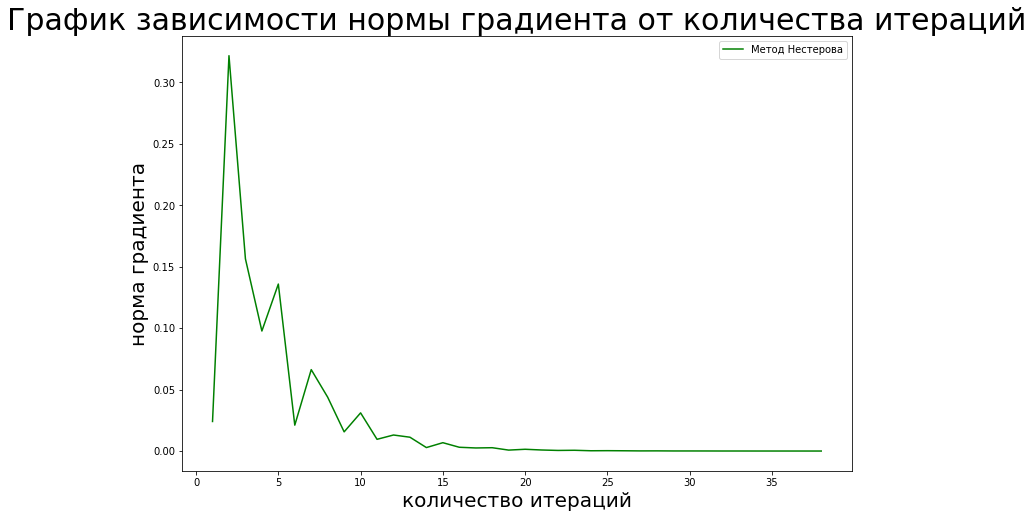

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(x1_3,y2_3,color = 'g',label='Метод Нестерова',markersize = 10)
plt.title('График зависимости нормы градиента от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("норма градиента",fontsize=20)
plt.legend()
plt.show() 

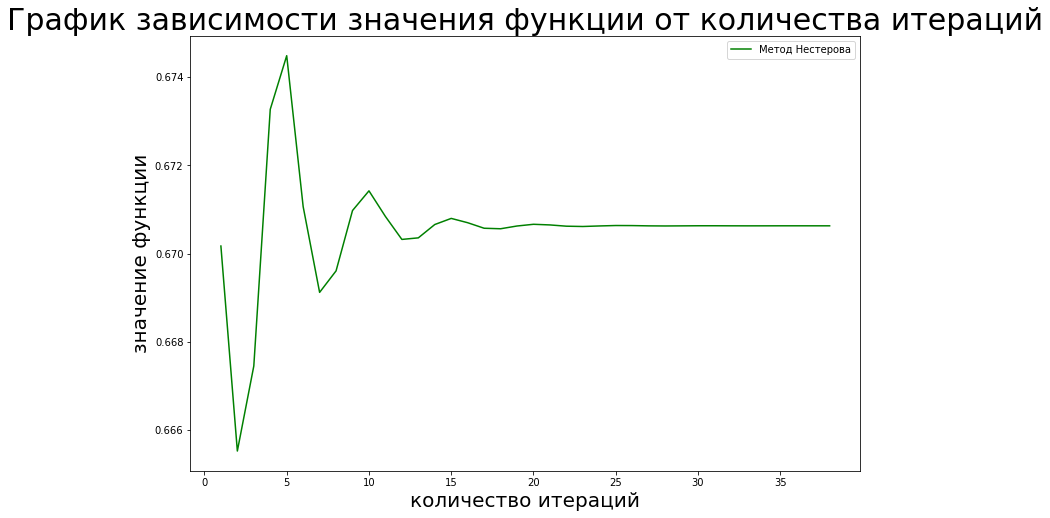

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(x1_3,y1_3,color = 'g',label='Метод Нестерова',markersize = 10)
plt.title('График зависимости значения функции от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("значение функции",fontsize=20)
plt.legend()
plt.show() 

Cравним теперь все три метода.

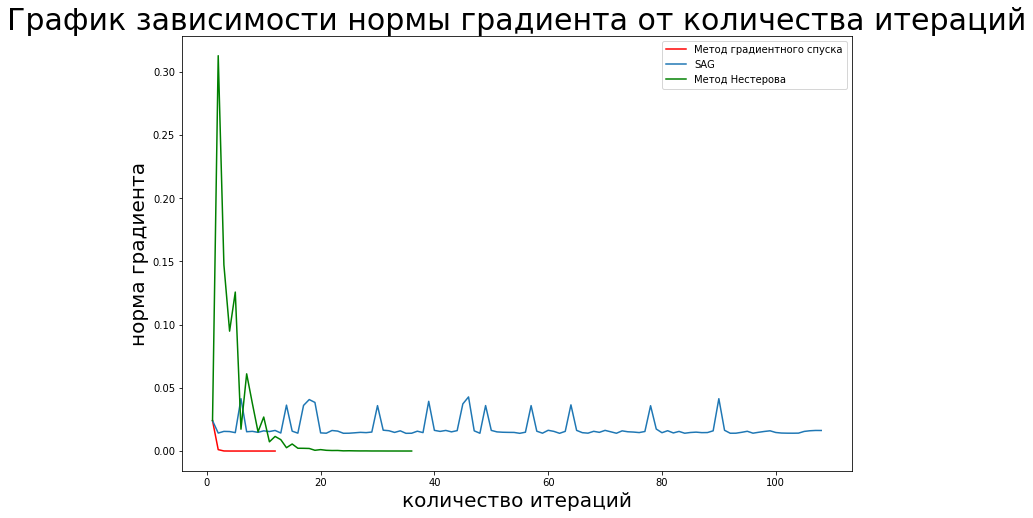

In [395]:
plt.figure(figsize=(12, 8))
plt.plot(x1,y2,color = 'r',label='Метод градиентного спуска',markersize = 10)
plt.plot(x1_2,y2_2,label='SAG',markersize = 10)
plt.plot(x1_3,y2_3,color = 'g',label='Метод Нестерова',markersize = 10)
plt.title('График зависимости нормы градиента от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("норма градиента",fontsize=20)
plt.legend()
plt.show() 

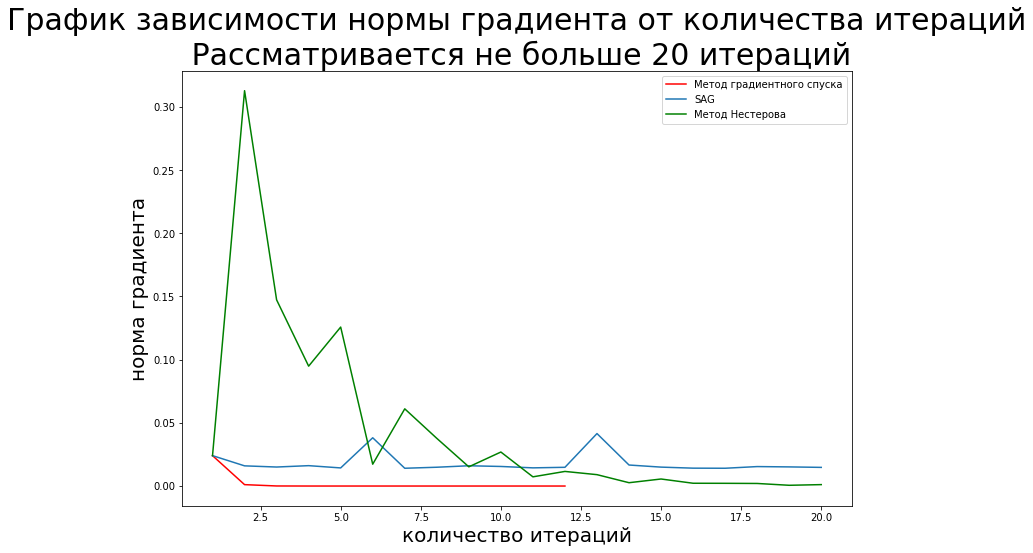

In [482]:
plt.figure(figsize=(12, 8))
plt.plot(x1,y2,color = 'r',label='Метод градиентного спуска',markersize = 10)
plt.plot(x1_2,y2_2,label='SAG',markersize = 10)
plt.plot(x1_3,y2_3,color = 'g',label='Метод Нестерова',markersize = 10)
plt.title('График зависимости нормы градиента от количества итераций\n Рассматривается не больше 20 итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("норма градиента",fontsize=20)
plt.legend()
plt.show() 

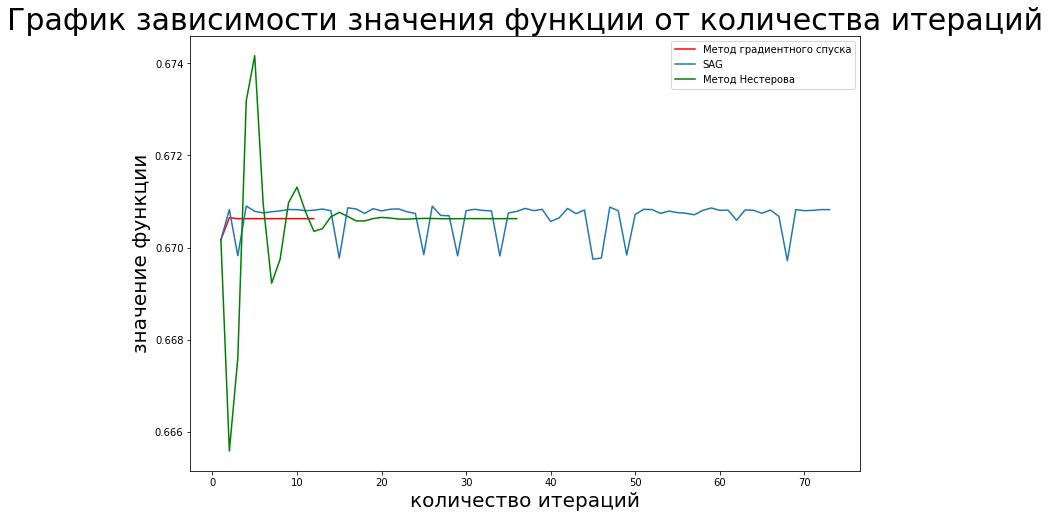

In [491]:
plt.figure(figsize=(12, 8))
plt.plot(x1,y1,color = 'r',label='Метод градиентного спуска',markersize = 10)
plt.plot(x1_2,y1_2,label='SAG',markersize = 10)
plt.plot(x1_3,y1_3,color = 'g',label='Метод Нестерова',markersize = 10)
plt.title('График зависимости значения функции от количества итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("значение функции",fontsize=20)
plt.legend()
plt.show() 

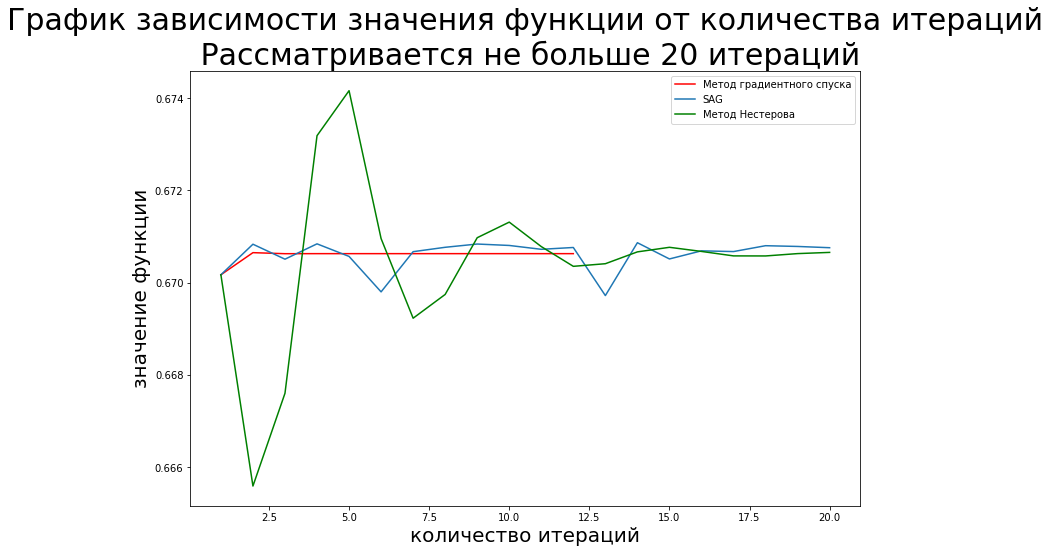

In [483]:
plt.figure(figsize=(12, 8))
plt.plot(x1,y1,color = 'r',label='Метод градиентного спуска',markersize = 10)
plt.plot(x1_2,y1_2,label='SAG',markersize = 10)
plt.plot(x1_3,y1_3,color = 'g',label='Метод Нестерова',markersize = 10)
plt.title('График зависимости значения функции от количества итераций\n Рассматривается не больше 20 итераций', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("значение функции",fontsize=20)
plt.legend()
plt.show() 

Теперь запустим метод Нестерова с разными $\mu$. Рассмотрим случаи с разным числом обусловленности, то есть возьмем $\mu = \frac{L}{10},\mu = \frac{L}{100},\mu = \frac{L}{1000},\mu = \frac{L}{10000}$ и сравним результаты в каждом случае.

In [407]:
xn_1, xn_2, xn_3, xn_4  = [],[],[],[]
yn1_1, yn1_2, yn1_3, yn1_4  = [],[],[],[]
yn2_1, yn2_2, yn2_3, yn2_4  = [],[],[],[]
L = 110

In [454]:
yn2_1  = []
xn_1  = []

In [401]:
def df2(X, y, w, k, C):
    l = len(y)
    w1 = np.zeros(112)
    for i in range(112):
        w1[i] = 1.0- 1.0 / (1.0 + math.exp(-y[i] * (X[i].dot(w))))
        
    w =  ((1.0 / l))*(X.transpose().dot(y)) * w1 -   C * w
    return w

In [455]:
def Nester(X, y, w, k, C): 
    x_1 = np.zeros(112)
    df_0 = df2(X, y, x_1, k, C)
    L = 110
    x_k = x_1 + k*df_0 + (L**(1/2)-(C)**(1/2))/(L**(1/2)+(C)**(1/2))*(x_1 - w)
    count = 1
    xn_1.append(count)
    yn1_1.append(abs(f(X, y, x_k, k, C)))
    yn2_1.append(ln.norm(df(X, y, x_k, k, C)))
    eps = 1e-3
    while ((ln.norm(x_k - x_1))>eps and count<270):
        w = x_1
        x_1 = x_k
        df_0 = df2(X, y, x_1, k, C)
        
        x_k = x_1 + k*df_0 + (L**(1/2)-(C)**(1/2))/(L**(1/2)+(C)**(1/2))*(x_1 - w)
        count = count + 1
        xn_1.append(count)
        yn1_1.append(abs(f(X, y, x_k, k, C)))
        yn2_1.append(ln.norm(df(X, y, x_k, k, C)))
        
        
    return x_k

In [456]:
k = 0.1
C = L/10
w = np.zeros(112)
w_prev = np.zeros(112)
w_ans = (Nester(X, y, w, k, C))

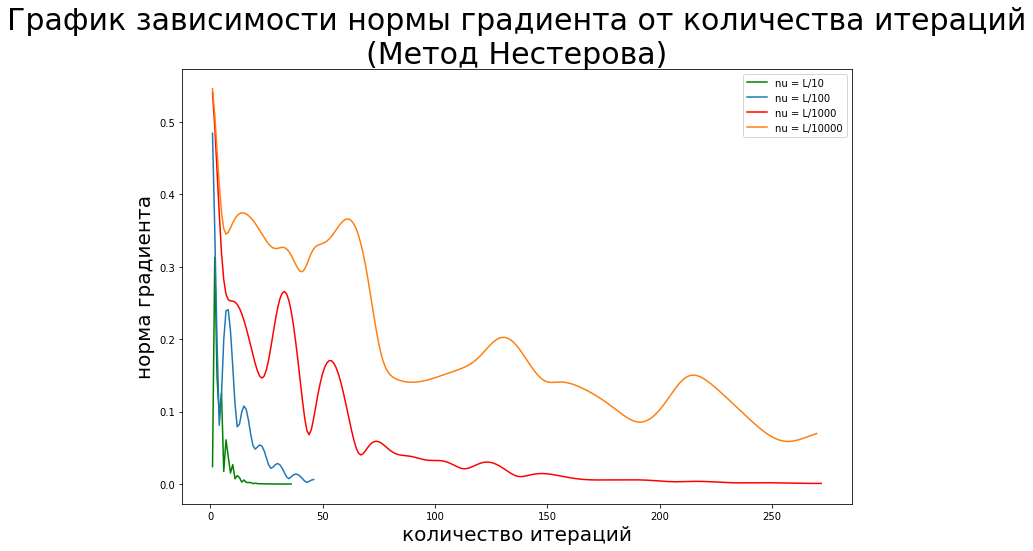

In [461]:
plt.figure(figsize=(12, 8))
plt.plot(x1_3,y2_3,color = 'g',label='nu = L/10',markersize = 10)
plt.plot(xn_2,yn2_2,label='nu = L/100',markersize = 10)
plt.plot(xn_3,yn2_3,color = 'r',label='nu = L/1000',markersize = 10)
plt.plot(xn_4,yn2_4,label='nu = L/10000',markersize = 10)
plt.title('График зависимости нормы градиента от количества итераций\n(Метод Нестерова)', fontsize=30)
plt.xlabel("количество итераций",fontsize=20)
plt.ylabel("норма градиента",fontsize=20)
plt.legend()
plt.show() 